In [1]:
import numpy as np
import pcl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

In [2]:
cloud_XYZI = pcl.load_XYZI('pcd_data/0000000005.pcd')
cloud_np = np.array(cloud_XYZI)

In [3]:
cloud_x = cloud_np[:, 0]
cloud_y = cloud_np[:, 1]
cloud_z = cloud_np[:, 2]

x_max, x_min = np.max(cloud_x), np.min(cloud_x)
y_max, y_min = np.max(cloud_y), np.min(cloud_y)
z_max, z_min = np.max(cloud_z), np.min(cloud_z)

print('x_max: ', x_max,  ', x_min: ', x_min)
print('y_max: ', y_max, ', y_min: ', y_min)
print('z_max: ', z_max, ', z_min: ', z_min)
print('Number of points: ', cloud_XYZI.size)

x_max:  79.654 , x_min:  -79.066
y_max:  34.076 , y_min:  -37.004
z_max:  2.855 , z_min:  -26.884
Number of points:  114969


In [4]:
cloud_XYZ = pcl.PointCloud()
cloud_XYZ.from_array(cloud_np[:, 0:3])

In [5]:
colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}
axes_limits = [
    [int(x_min*1.2), int(x_max*1.2)], # X axis range
    [int(y_min*1.2), int(y_max*1.2)], # Y axis range
    [-5, 5]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']


In [6]:
def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='red'):
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0], 
        [4, 5], [5, 6], [6, 7], [7, 4], 
        [0, 4], [1, 5], [2, 6], [3, 7] 
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw= 1.0)

In [7]:
def draw_point_cloud(cloud, ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        
        cloud = np.array(cloud) # Covert point cloud to numpy array
        no_points = np.shape(cloud)[0]
        point_size = 10**(3- int(np.log10(no_points))) 
        if np.shape(cloud)[1] == 4: 
            ax.scatter(*np.transpose(cloud[:, axes]), s = point_size, c=cloud[:, 3], cmap='gray')
        elif np.shape(cloud)[1] == 3:  
            ax.scatter(*np.transpose(cloud[:, axes]), s = point_size, c='b', alpha = 0.7)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2: 
            ax.set_xlim3d(axes_limits[axes[0]])
            ax.set_ylim3d(axes_limits[axes[1]])
            ax.set_zlim3d(axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else: 
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
        ax.set_title(title)    

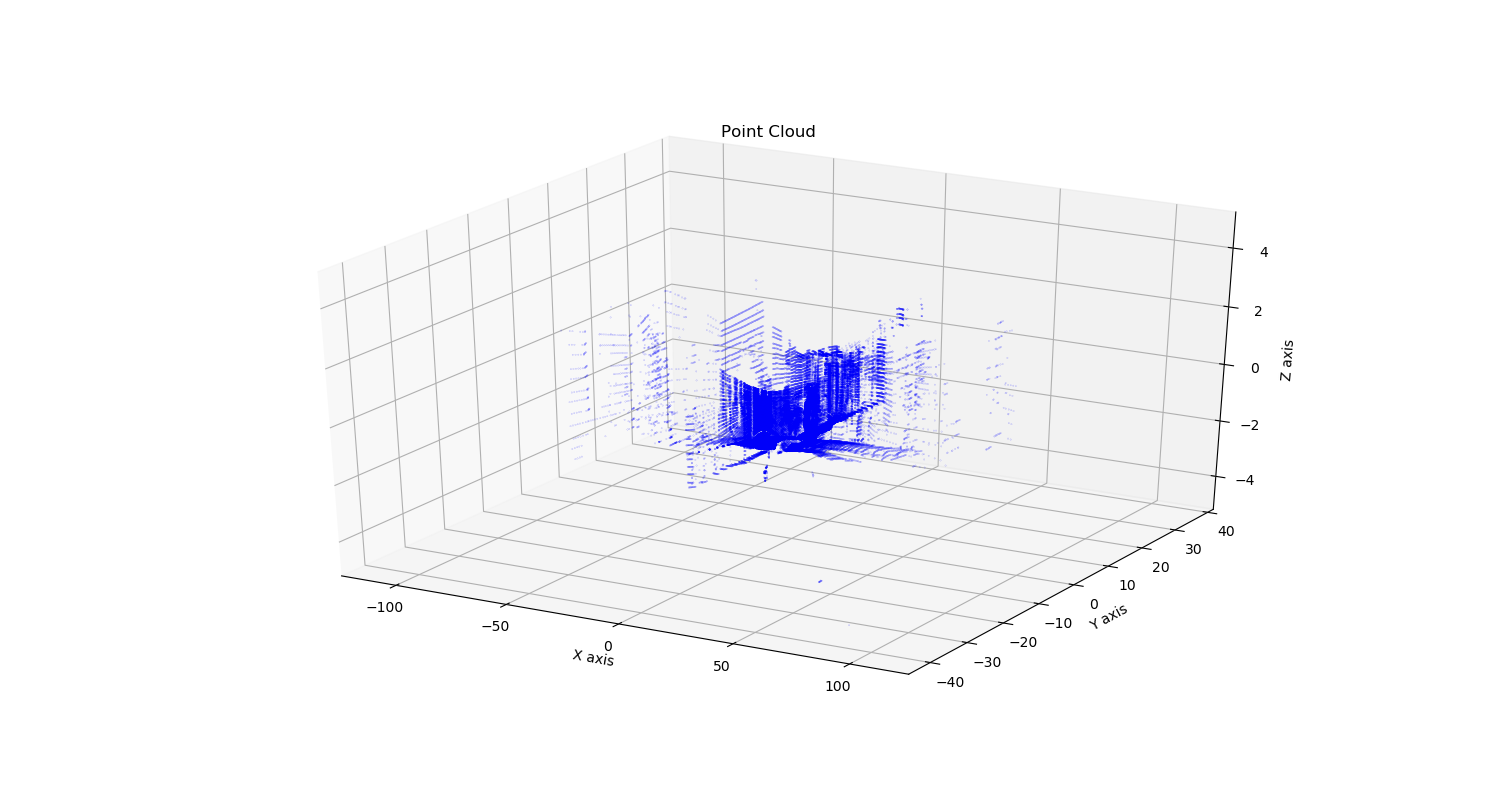

In [9]:
%matplotlib widget

#too slow - skip this !
f = plt.figure(figsize=(15, 8))
ax = f.add_subplot(111, projection='3d')  
draw_point_cloud(cloud_XYZ, ax, 'Point Cloud', xlim3d=(-120,120))
plt.show()

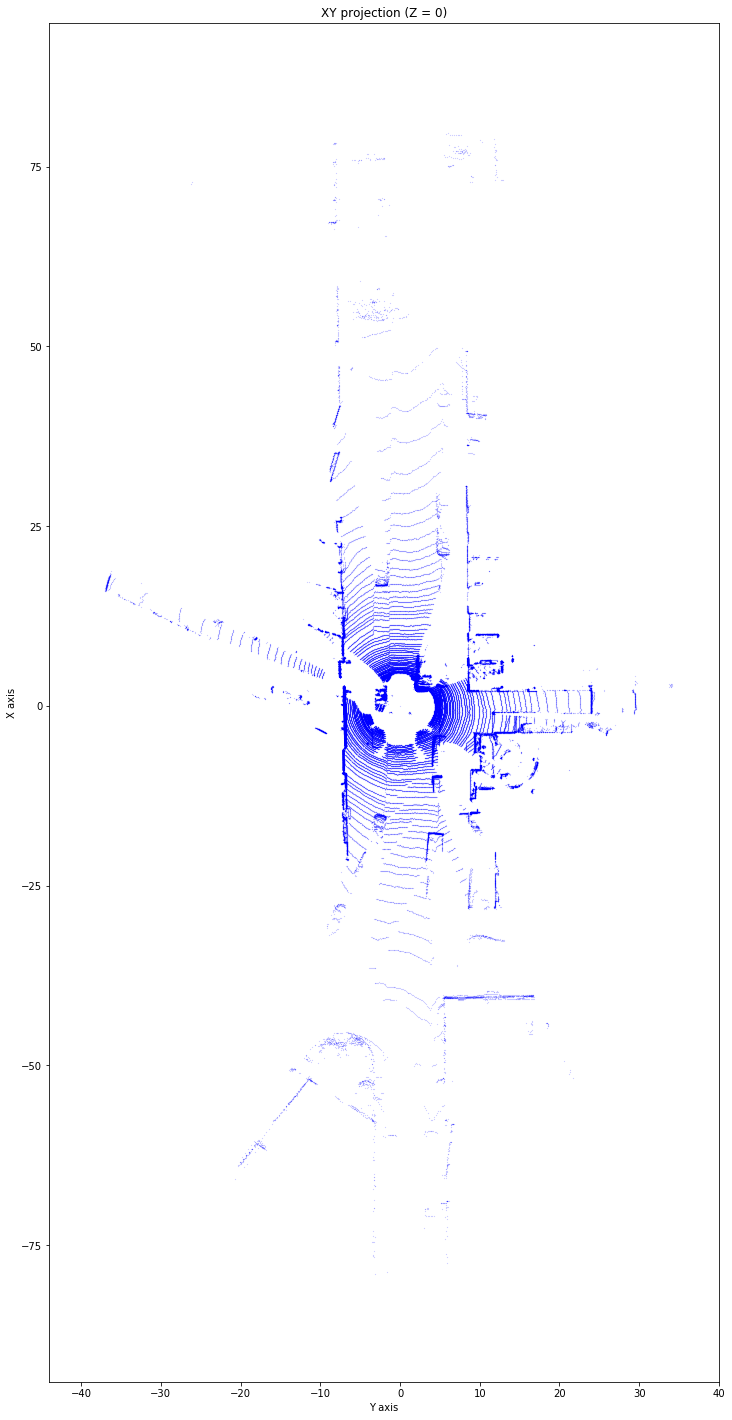

In [8]:
f, ax3 = plt.subplots(1, 1, figsize=(12, 25))

draw_point_cloud(cloud_XYZ,
        ax3, 
        'XY projection (Z = 0)', 
        axes=[1, 0] # X and Y axes
    )

plt.show()

In [9]:
def voxel_filter(cloud, leaf_sizes): #downsample the point cloud

    sor = cloud.make_voxel_grid_filter()
    size_x, size_y, size_z = leaf_sizes
    sor.set_leaf_size(size_x, size_y, size_z)
    cloud_voxel_filtered = sor.filter()
    
    return cloud_voxel_filtered

In [13]:
cloud_voxel_filtered = voxel_filter(cloud_XYZ, [0.3, 0.3, 0.3])
print('Input cloud size: ', cloud_XYZ.size, ', size after voxel-filtering: ', cloud_voxel_filtered.size)
print('Reduction to : ', cloud_voxel_filtered.size / cloud_XYZ.size * 100, ' of the actual size')

Input cloud size:  114969 , size after voxel-filtering:  14101


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [12]:
def roi_filter(cloud, x_roi, y_roi, z_roi): # cut off the part that is not needed
    clipper = cloud.make_cropbox()
    cloud_roi_filtered= pcl.PointCloud()
    xc_min, xc_max = x_roi
    yc_min, yc_max = y_roi
    zc_min, zc_max = z_roi
    clipper.set_MinMax(xc_min, yc_min, zc_min, 0, xc_max, yc_max, zc_max, 0)
    cloud_roi_filtered =clipper.filter()
    return cloud_roi_filtered

In [13]:
axes_limits = [
    [-30, 30], # X axis range
    [-6, 8], # Y axis range
    [-3, 3]   # Z axis range
]

cloud_roi_filtered = roi_filter(cloud_voxel_filtered, axes_limits[0], axes_limits[1], axes_limits[2])
print('Input cloud size: ', cloud_XYZ.size)
print('Size after voxel-filtering: ', cloud_voxel_filtered.size)
print('Size after ROI filter: ', cloud_roi_filtered.size)

Input cloud size:  114969
Size after voxel-filtering:  14101
Size after ROI filter:  4546


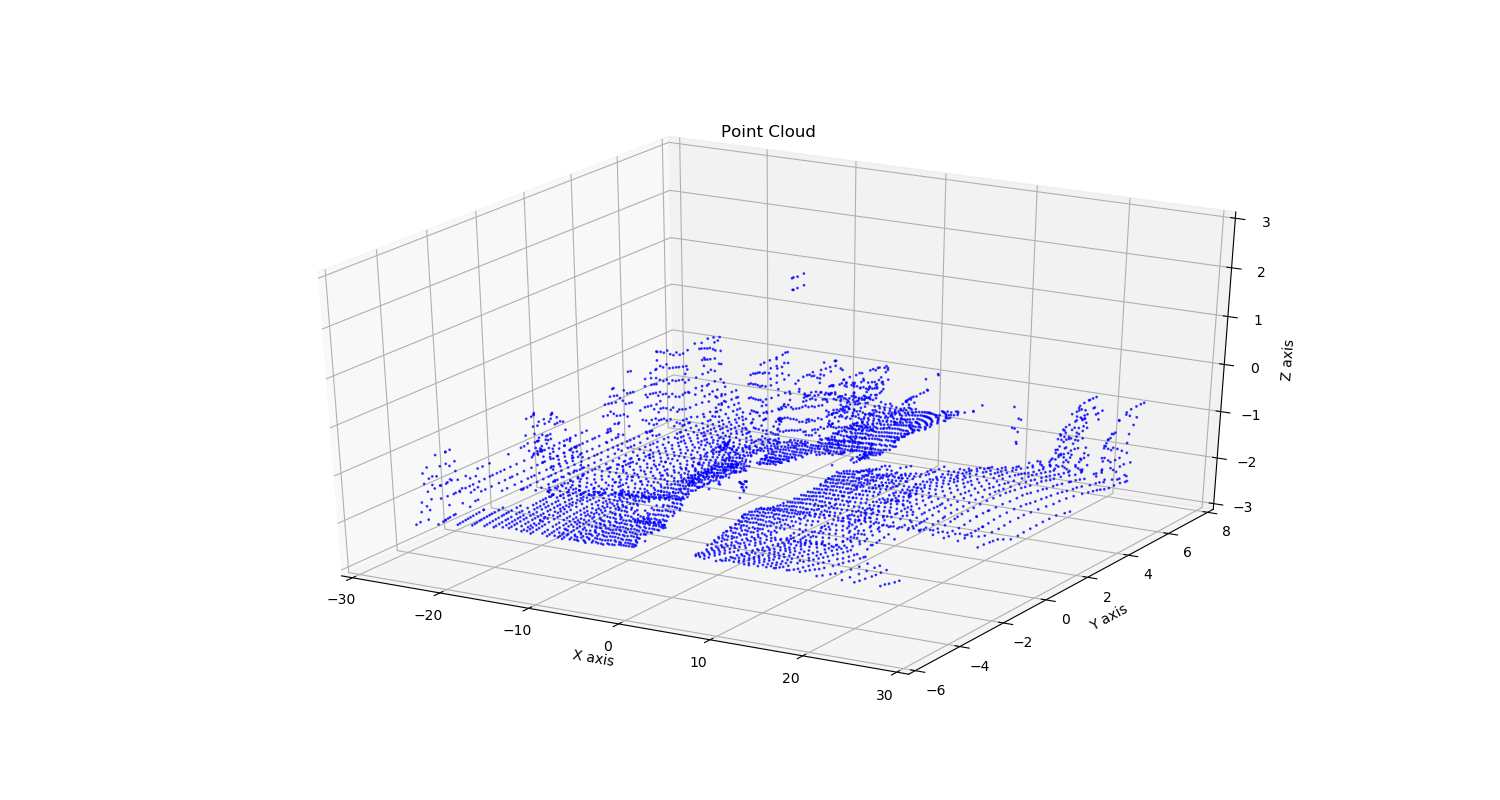

In [14]:
f = plt.figure(figsize=(15, 8))
ax = f.add_subplot(111, projection='3d') 
draw_point_cloud(cloud_roi_filtered, ax, 'Point Cloud', xlim3d=(-30,30))
plt.show()

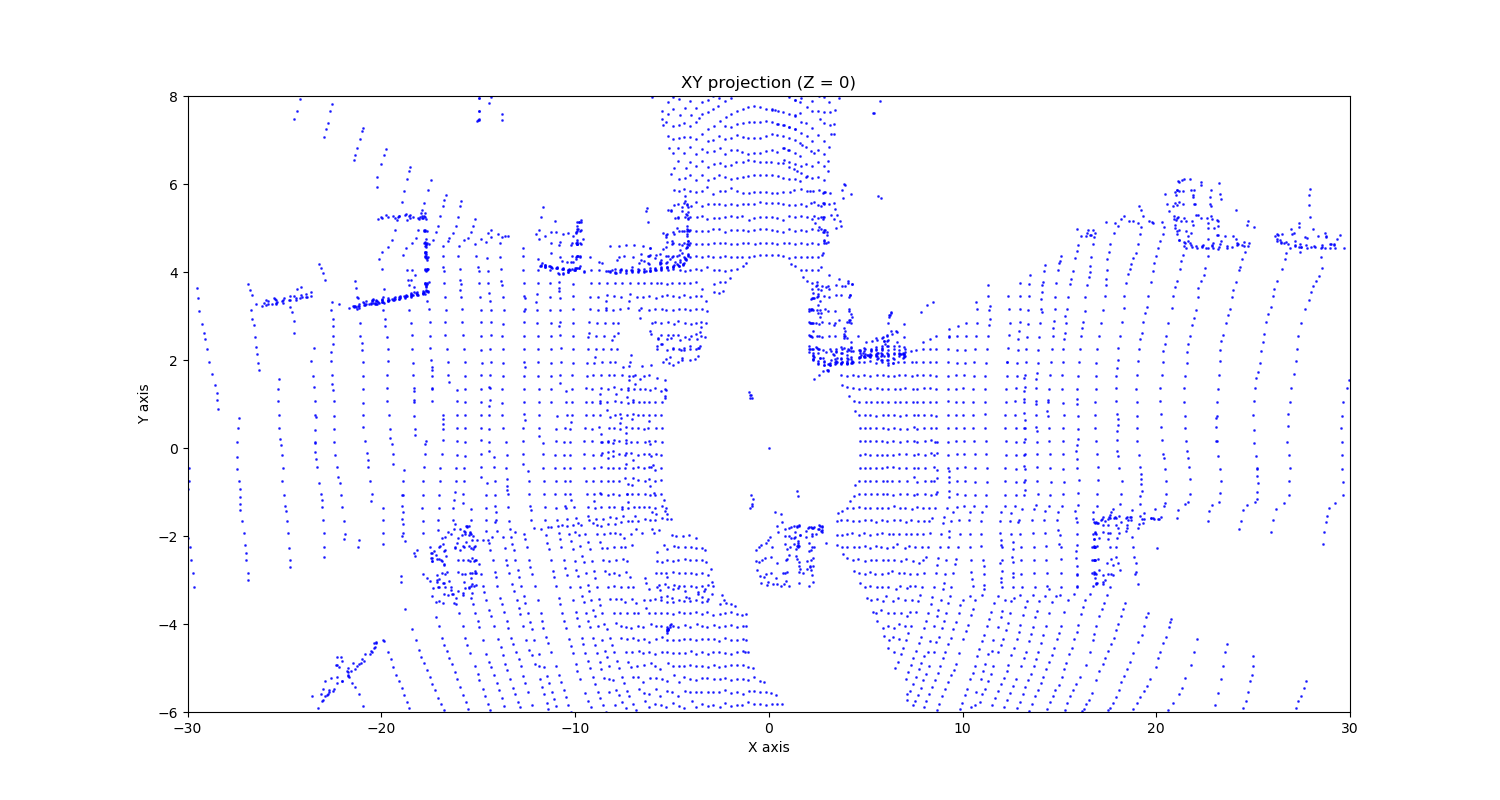

In [15]:
#no need, the previous one is interactive

f = plt.figure(figsize=(15, 8))
ax = f.add_subplot(111) 
draw_point_cloud(cloud_roi_filtered,
        ax, 
        'XY projection (Z = 0)', 
        axes=[0, 1])
plt.show()

In [16]:
def plane_segmentation(cloud, dist_thold, max_iter):

    seg = cloud.make_segmenter_normals(ksearch=50)
    seg.set_optimize_coefficients(True)
    seg.set_model_type(pcl.SACMODEL_NORMAL_PLANE)
    seg.set_method_type(pcl.SAC_RANSAC)
    seg.set_distance_threshold(dist_thold)
    seg.set_max_iterations(max_iter)
    indices, coefficients = seg.segment()
    return indices, coefficients
    

In [17]:
indices, coefficients = plane_segmentation(cloud_roi_filtered, 0.3, 100)
if len(indices) == 0:
        print('Could not estimate a planar model for the given dataset.')
print('Model coefficients: ' + str(coefficients[0]) + ', ' + str(
        coefficients[1]) + ', ' + str(coefficients[2]) + ', ' + str(coefficients[3]))

Model coefficients: -0.005974809639155865, 0.019597312435507774, 0.9997901320457458, 1.7547153234481812


In [18]:
cloud_plane = cloud_roi_filtered.extract(indices, negative=False)
cloud_obsts = cloud_roi_filtered.extract(indices, negative = True)
print('Size of the plane: ' + str(cloud_plane.size) + ', size of the obstacles: ' + str(cloud_obsts.size))

Size of the plane: 3432, size of the obstacles: 1114


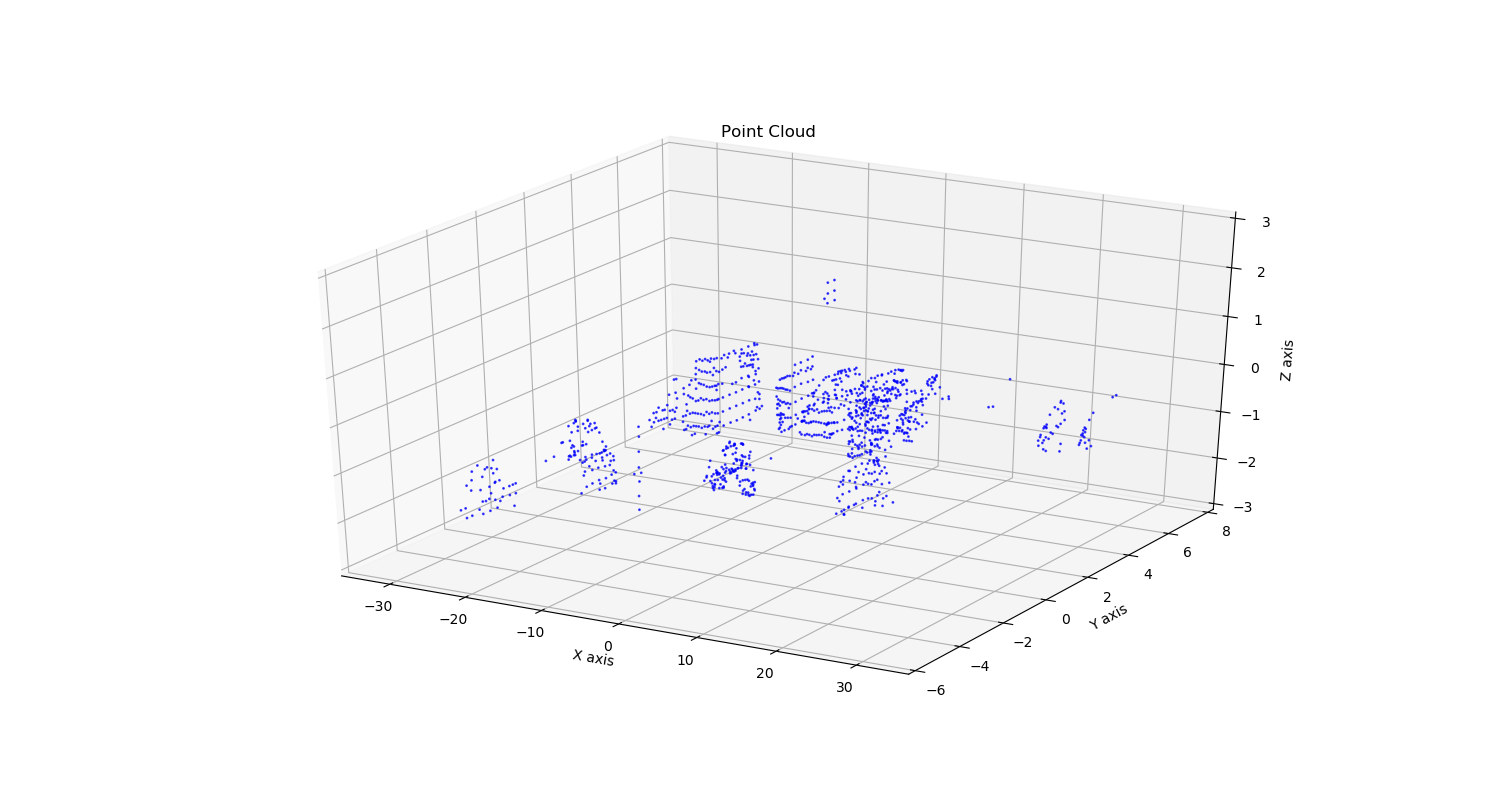

In [22]:
f = plt.figure(figsize=(15, 8))
ax = f.add_subplot(111, projection='3d') 
draw_point_cloud(cloud_obsts, ax, 'Point Cloud', xlim3d=(-35,35))
plt.show()

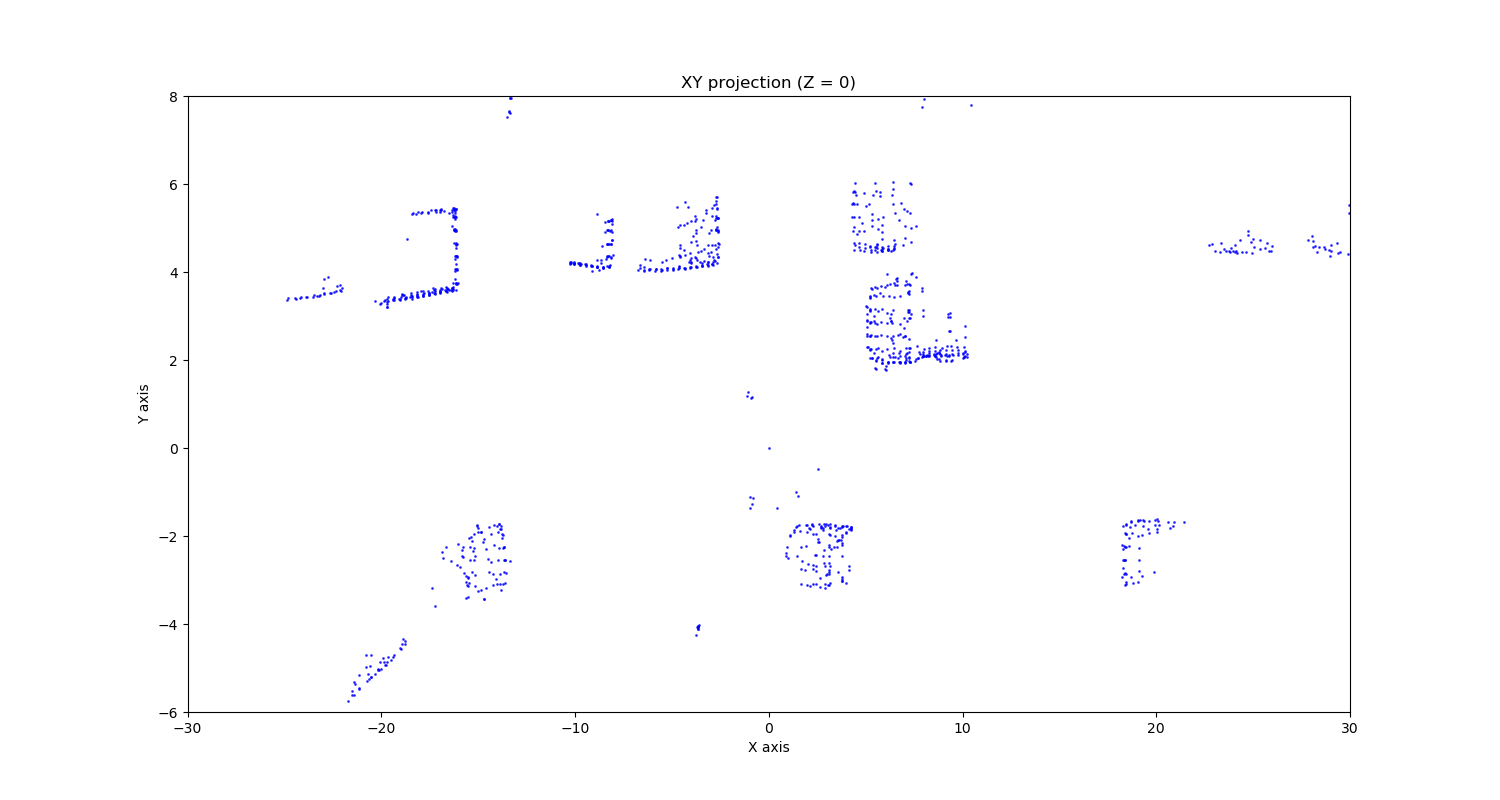

In [23]:
f = plt.figure(figsize=(15, 8))
ax = f.add_subplot(111) 
draw_point_cloud(np.array(cloud_obsts),
        ax, 
        'XY projection (Z = 0)', 
        axes=[0, 1] # X and Z axes
    )
plt.show()

In [24]:
def clustering(cloud, tol, min_size, max_size):

    tree = cloud.make_kdtree()
    ec = cloud.make_EuclideanClusterExtraction()
    ec.set_ClusterTolerance(tol)
    ec.set_MinClusterSize(min_size)
    ec.set_MaxClusterSize(max_size)
    ec.set_SearchMethod(tree)
    cluster_indices = ec.Extract()
    return cluster_indices

In [25]:
cluster_indices = clustering(cloud_obsts, 0.7, 30, 400)

In [26]:
def get_cluster_box_list(cluster_indices, cloud_obsts):

    cloud_cluster_list =[]
    box_coord_list =[]

    for j, indices in enumerate(cluster_indices):
        points = np.zeros((len(indices), 3), dtype=np.float32)
        for i, indice in enumerate(indices):
            
            points[i][0] = cloud_obsts[indice][0]
            points[i][1] = cloud_obsts[indice][1]
            points[i][2] = cloud_obsts[indice][2]
        cloud_cluster = pcl.PointCloud()
        cloud_cluster.from_array(points)
        cloud_cluster_list.append(cloud_cluster)
        x_max, x_min = np.max(points[:, 0]), np.min(points[:, 0])
        y_max, y_min = np.max(points[:, 1]), np.min(points[:, 1])
        z_max, z_min = np.max(points[:, 2]), np.min(points[:, 2])
        box = np.zeros([8, 3])
        box[0, :] =[x_min, y_min, z_min]
        box[1, :] =[x_max, y_min, z_min]
        box[2, :] =[x_max, y_max, z_min]
        box[3, :] =[x_min, y_max, z_min]
        box[4, :] =[x_min, y_min, z_max]
        box[5, :] =[x_max, y_min, z_max]
        box[6, :] =[x_max, y_max, z_max]
        box[7, :] =[x_min, y_max, z_max]
        box = np.transpose(box)
        box_coord_list.append(box)
    return cloud_cluster_list, box_coord_list    
    

In [27]:
cloud_cluster_list, box_coord_list = get_cluster_box_list(cluster_indices, cloud_obsts)

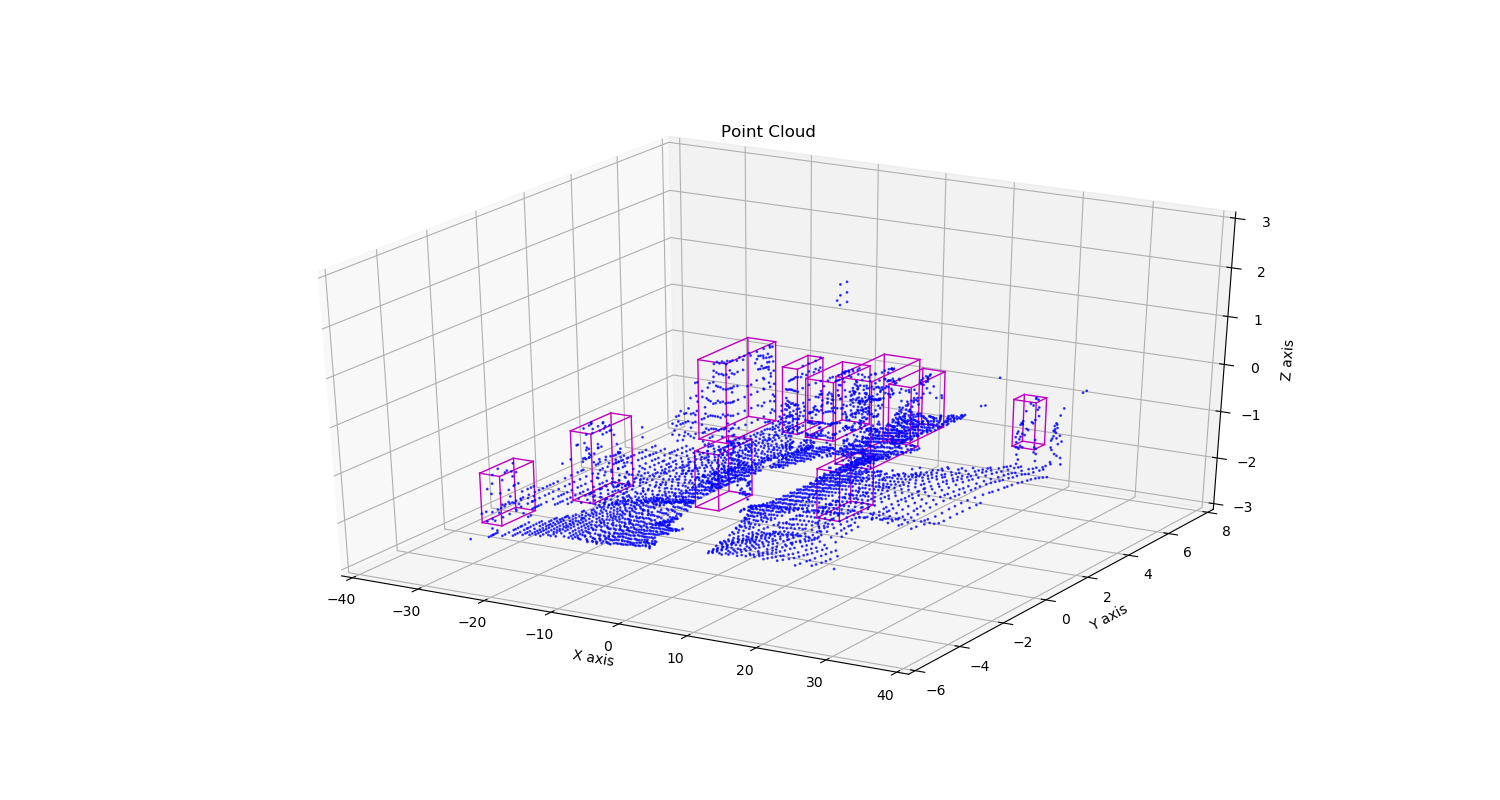

In [28]:
f = plt.figure(figsize=(15, 8))
ax = f.add_subplot(111, projection='3d') 
draw_point_cloud(cloud_roi_filtered, ax, 'Point Cloud', xlim3d=(-40,40))
for box in box_coord_list:
     draw_box(ax, box, axes=[0, 1, 2], color='m')
plt.show()

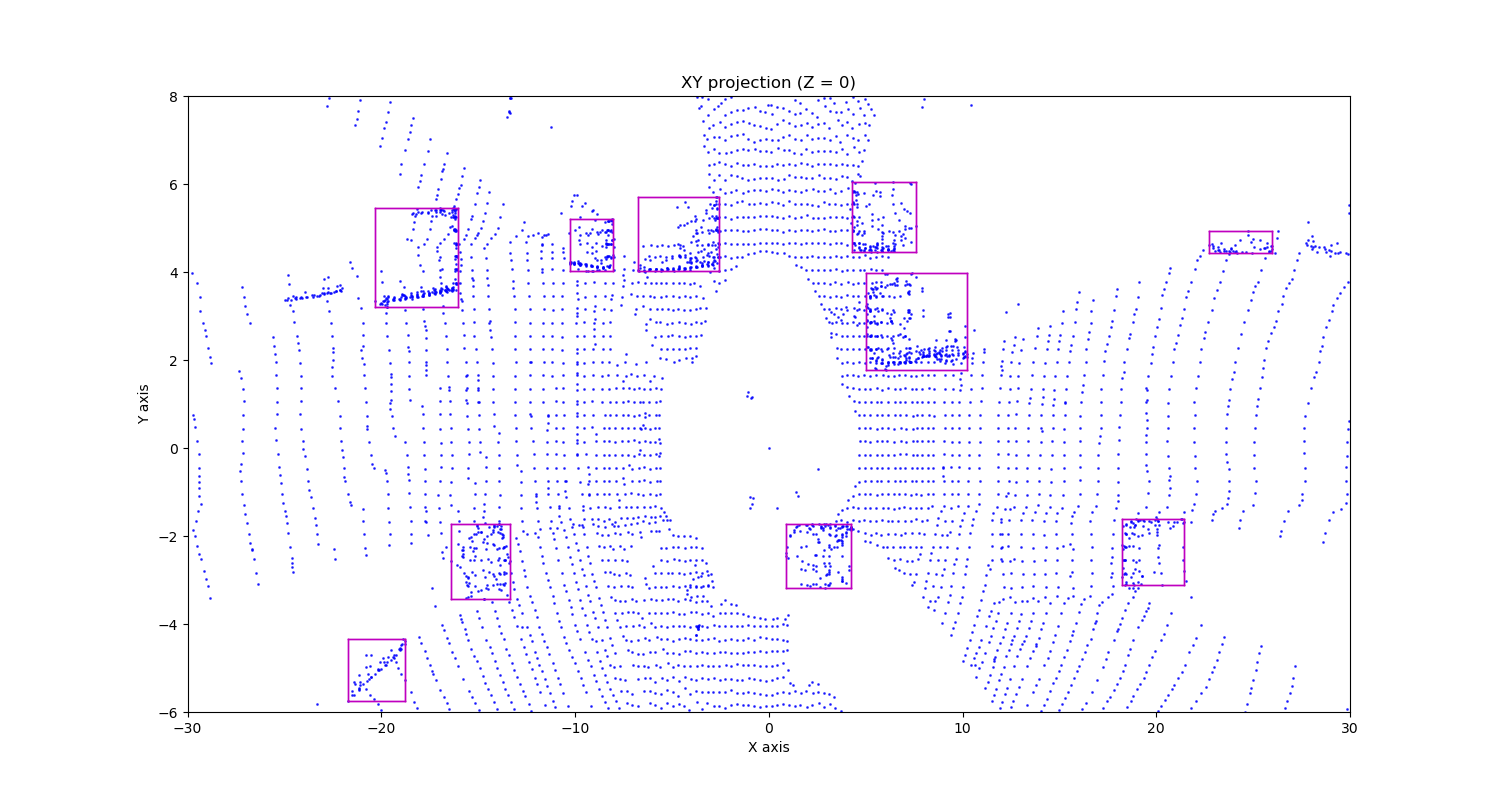

In [93]:
f = plt.figure(figsize=(15, 8))
ax = f.add_subplot(111) 
draw_point_cloud(np.array(cloud_roi_filtered), ax, 'XY projection (Z = 0)', axes=[0, 1])
for box in box_coord_list:
     draw_box(ax, box, axes=[0, 1], color='m')
plt.show()